In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from registration_utilities import *

from collections import defaultdict

In [2]:
volume_landmark_names_unsided = ['12N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'LC',
                                 'LRt', 'Pn', 'R', 'RtTg', 'Tz', 'VLL', 'sp5']
linear_landmark_names_unsided = ['outerContour']

labels_unsided = volume_landmark_names_unsided + linear_landmark_names_unsided
labels_unsided_indices = dict((j, i+1) for i, j in enumerate(labels_unsided))  # BackG always 0

labelMap_unsidedToSided = {'12N': ['12N'],
                            '5N': ['5N_L', '5N_R'],
                            '6N': ['6N_L', '6N_R'],
                            '7N': ['7N_L', '7N_R'],
                            '7n': ['7n_L', '7n_R'],
                            'AP': ['AP'],
                            'Amb': ['Amb_L', 'Amb_R'],
                            'LC': ['LC_L', 'LC_R'],
                            'LRt': ['LRt_L', 'LRt_R'],
                            'Pn': ['Pn_L', 'Pn_R'],
                            'R': ['R_L', 'R_R'],
                            'RtTg': ['RtTg'],
                            'Tz': ['Tz_L', 'Tz_R'],
                            'VLL': ['VLL_L', 'VLL_R'],
                            'sp5': ['sp5'],
                           'outerContour': ['outerContour']}

labelMap_sidedToUnsided = {n: nu for nu, ns in labelMap_unsidedToSided.iteritems() for n in ns}

from itertools import chain
labels_sided = list(chain(*(labelMap_unsidedToSided[name_u] for name_u in labels_unsided)))
labels_sided_indices = dict((j, i+1) for i, j in enumerate(labels_sided)) # BackG always 0

downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [3]:
atlasAlignParams_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams_atlas'

In [4]:
# T_final = {}

parameters_allStacks_allLandmarks = defaultdict(dict)
atlas_centroid_allStacks_allLandmarks = defaultdict(dict)
test_centroid_allStacks_allLandmarks = defaultdict(dict)

for i, stack in enumerate(['MD589', 'MD594', 'MD585', 'MD590', 'MD593', 'MD592', 'MD591', 'MD595', 'MD598', 'MD602', 'MD603']):

#     with open(atlasAlignParams_rootdir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
#         lines = f.readlines()
#     T_final[stack] = np.array(map(float, lines[1].strip().split()))
    
    for name in labels_sided:

        tf_fn = atlasAlignParams_rootdir + '/%(stack)s/%(stack)s_%(name)s_transformUponAffineProjection.txt' % \
                            {'stack': stack, 'name': name}
        
        if not os.path.exists(tf_fn):
            continue
        
        with open(tf_fn, 'r') as f:
            lines = f.readlines()
            params = np.array(map(float, lines[0].strip().split()))
            atlas_centroid = np.array(map(float, lines[1].strip().split()))
            test_centroid = np.array(map(float, lines[2].strip().split()))

        parameters_allStacks_allLandmarks[stack][name] = params
        atlas_centroid_allStacks_allLandmarks[stack][name] = atlas_centroid
        test_centroid_allStacks_allLandmarks[stack][name] = test_centroid
        
parameters_allStacks_allLandmarks.default_factory = None
atlas_centroid_allStacks_allLandmarks.default_factory = None
test_centroid_allStacks_allLandmarks.default_factory = None

In [25]:
[name for c, name in sorted([(c[0], name) for name, c in test_centroid_allStacks_allLandmarks['MD585'].iteritems()])]

['Pn_L',
 'Pn_R',
 'R_L',
 'R_R',
 'VLL_L',
 'RtTg',
 'VLL_R',
 'Tz_L',
 'Tz_R',
 '5N_L',
 '5N_R',
 '7n_L',
 'LC_L',
 '6N_L',
 '6N_R',
 'LC_R',
 '7n_R',
 '7N_L',
 '7N_R',
 'Amb_L',
 'Amb_R',
 '12N',
 'AP',
 'LRt_L',
 'LRt_R']

In [58]:
names_sorted_by_x = ['Pn_L',
 'Pn_R',
 'R_L',
 'R_R',
 'VLL_L',
 'VLL_R',
 'RtTg',
 'Tz_L',
 'Tz_R',
 '5N_L',
 '5N_R',
 'LC_L',
 'LC_R',
 '6N_L',
 '6N_R',
 '7n_L',
 '7n_R',
 '7N_L',
 '7N_R',
 'Amb_L',
 'Amb_R',
 '12N',
 'AP',
 'LRt_L',
 'LRt_R']

In [59]:
txs_allLandmarks = defaultdict(list)
tys_allLandmarks = defaultdict(list)
tzs_allLandmarks = defaultdict(list)

translations_allStack_allLandmarks = defaultdict(dict)

for stack, lm_tforms in parameters_allStacks_allLandmarks.iteritems():
    for name, T in lm_tforms.iteritems():
        Tm = np.reshape(T, (3,4))
        t = Tm[:, 3]
        R = Tm[:, :3]
        translations_allStack_allLandmarks[stack][name] = t
        
#         txs_allLandmarks[name].append(t[0])
#         tys_allLandmarks[name].append(t[1])
#         tzs_allLandmarks[name].append(t[2])
        
        txs_allLandmarks[name].append(t[0] * xy_pixel_distance_downsampled)
        tys_allLandmarks[name].append(t[1] * xy_pixel_distance_downsampled)
        tzs_allLandmarks[name].append(t[2] * xy_pixel_distance_downsampled)
    
translations_allStack_allLandmarks.default_factory = None

In [60]:
names2_sorted_by_x = []
for name in names_sorted_by_x:
    if '_' in name:
        name_u, suffix = name.split('_')
        names2_sorted_by_x.append(name_u + '(' + suffix + ')')
    else:
        names2_sorted_by_x.append(name)

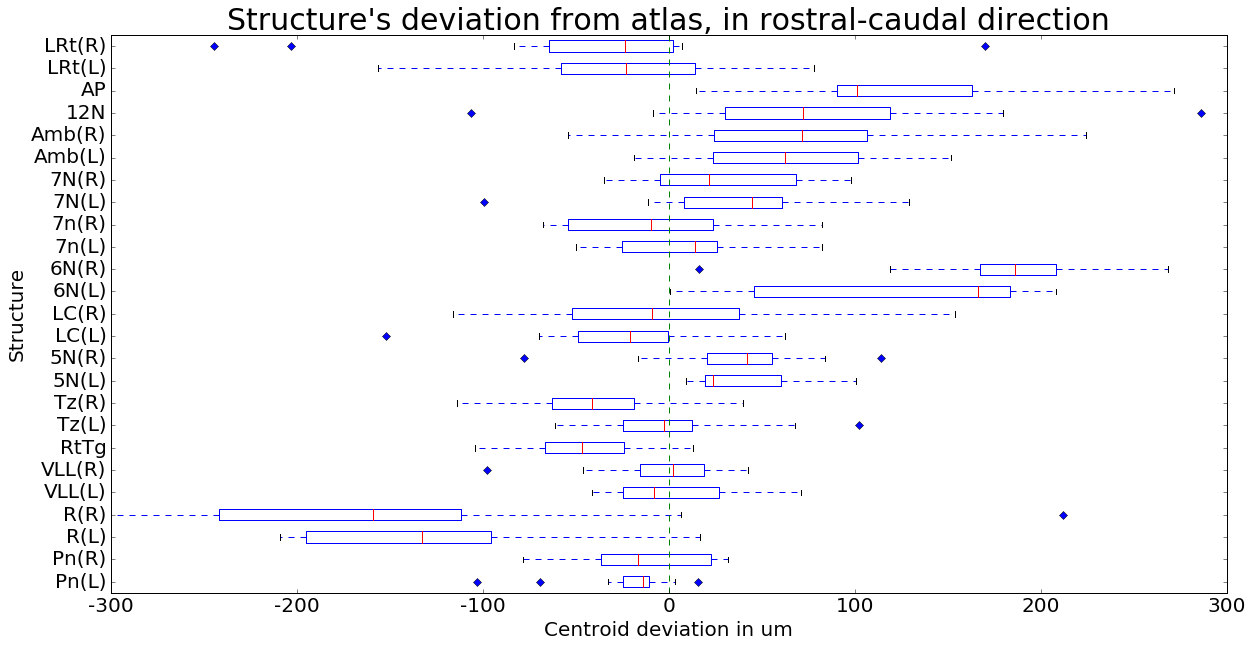

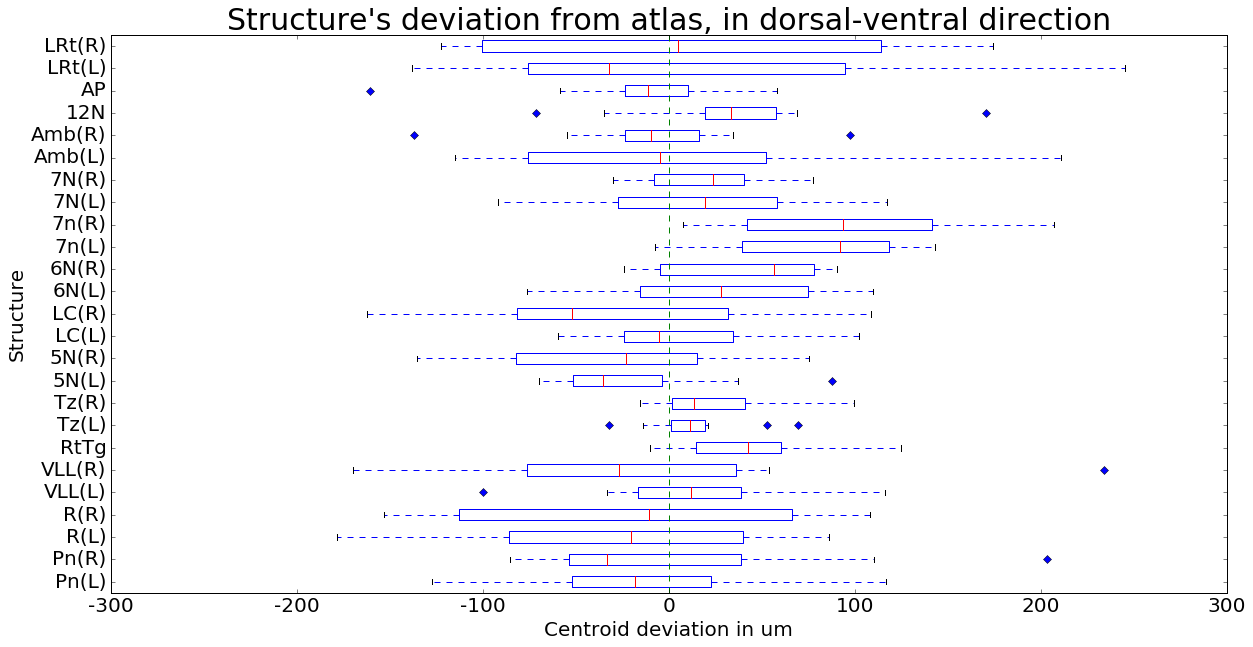

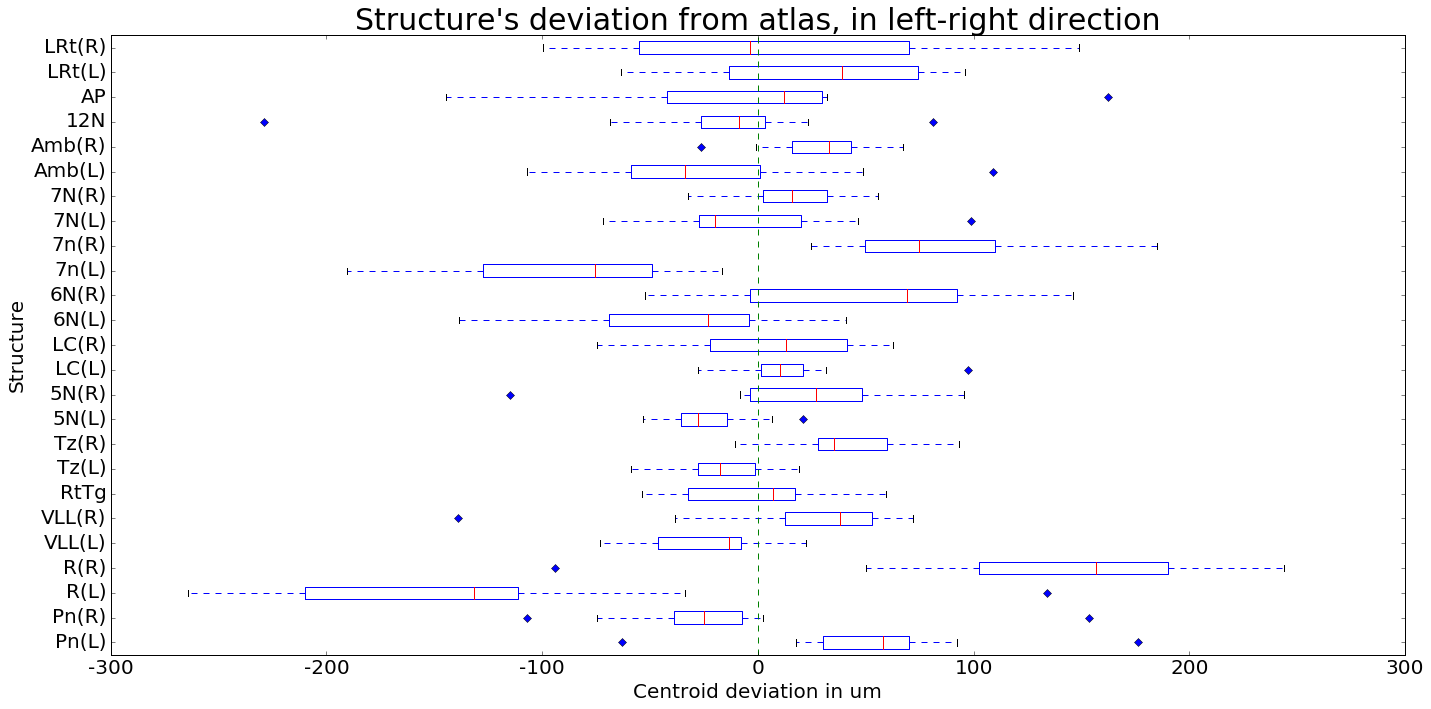

In [79]:
# fig, axes = plt.subplots(3, 1, figsize=(20,40), squeeze=True)

axes = [None for _ in range(3)]

for i, (d, v) in enumerate(zip([txs_allLandmarks, tys_allLandmarks, tzs_allLandmarks], ['tx', 'ty', 'tz'])):

#     names = sorted(d.keys())
    data = np.array([d[name] for name in names_sorted_by_x]).T

    fig, axes[i] = plt.subplots(1,1,figsize=(20,10))
    
    axes[i].boxplot(data, 0, 'gD', 0);
    axes[i].set_xlim([-300, 300])
    axes[i].set_xticks(np.arange(-300, 400, 100));
    axes[i].set_xticklabels(np.arange(-300, 400, 100), fontsize=20);
    axes[i].set_xlabel('Centroid deviation in um', fontsize=20);
    if v == 'tx':
        direction = 'rostral-caudal'
    elif v == 'ty':
        direction = 'dorsal-ventral'
    elif v == 'tz':
        direction = 'left-right'
        
    axes[i].set_title('Structure\'s deviation from atlas, in %s direction' % direction, fontsize=30)
    axes[i].set_ylabel('Structure', fontsize=20)
    axes[i].set_yticks(1 + np.arange(len(names2_sorted_by_x)))
    axes[i].set_yticklabels(names2_sorted_by_x, rotation='0', fontsize=20)
    axes[i].axvline(0, color='g', ls='dashed')
    
    
# plt.setp(axes, xticks=range(1, 1+data.shape[1]), xticklabels=names)
plt.tight_layout(h_pad=5.0);
plt.show();